In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from NCA import CA, totalistic
import pygame, pygame_gui

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    # blur = torch.exp(-rm**2 / s**2)
    blur = torch.rand_like(rm)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = state[:, :, i, j] + blur[count_i, count_j]
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = state[:, :, i, j] * blur[count_i, count_j]
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), CHANNELS)
    
    return cdim_order

# Lorenz stuff
import sys
sys.path.append('reservoir stuff/')
from Utils import *

inject_lorenz = False
L = (np.random.rand(), np.random.rand(), np.random.rand())
def inject_lorenz_globally_per_channel(state, lorenz, gain=0.5):
    '''
    inject lorenz (x, y, z) components into the CA by injecting a random component to each pixel
    '''
    for iL, l in enumerate(lorenz):
        state[:, -(iL + 1)] += torch.tanh(torch.Tensor([l])).cuda() * gain
    
    return state

# rand_idx = np.random.randint(0, 3, size=50*50)
def inject_lorenz_globally(state, lorenz, gain=0.5):
    '''
    inject lorenz (x, y, z) components into the CA by injecting a random component to each pixel
    '''
    lorenz_img = torch.Tensor(lorenz[rand_idx].reshape(RESX, RESY)).cuda()
    state[:, -1] = torch.sigmoid(lorenz_img) * gain
    
    return state

# Test

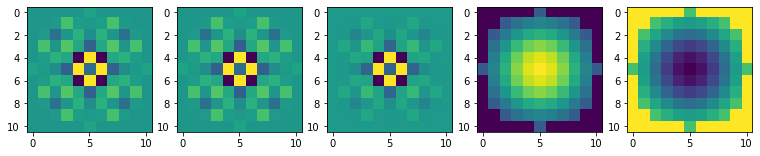

In [3]:
CHANNELS=6 # number of channels in grid
FILTERS=1 # number of filters per channel
HIDDEN=10 # number of hidden neurons

RADIUS=5 # radius of kernel
KCENTER=0. # radius of gaussian ring
KSMOOTH=0.9 # gaussian smoothing
OUTR=1. # outer ring of kernel
INR=0.  # inner ring of kernel
GAMP=-.1 # growth kernel amplitude


ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN,
        RADIUS=RADIUS, KCENTER=KCENTER, KSMOOTH=KSMOOTH, OUTR=OUTR, INR=INR, GAMP=GAMP).cuda() 


fig, ax = plt.subplots(1, 5, figsize=(13, 2.5))
ax[0].imshow(ca.rule.filter1[0, 0].cpu().detach().numpy())
ax[1].imshow(totalistic(ca.rule.filter1.detach())[0, 0].cpu().detach().numpy())
ax[2].imshow(totalistic(ca.rule.filter1 * ca.rule.decay_kernel)[0, 0].cpu().detach().numpy())
ax[3].imshow(ca.rule.decay_kernel.cpu().detach().numpy())
ax[4].imshow(ca.rule.growth_kernel.cpu().detach().numpy())

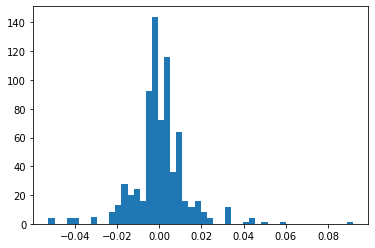

In [4]:
plt.hist((totalistic(ca.rule.filter1.detach()).cpu().detach().numpy()).reshape(-1), 50);

In [5]:
# brush properties
r = 40
s = 1

In [ ]:
# resolution of grid
RESX=250
RESY=250

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 3
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, CHANNELS)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

# CENTER SEED
seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
seed[:, :, RESX//2, RESY//2] = 1

# NOISE SEED
#seed = torch.randn(1, CHANNELS, RESX, RESY).cuda()


state = seed.clone()

# inject noise
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)

# lorenz stuff
rand_idx = np.random.randint(0, 3, size=RESX*RESY)
rand_gain = torch.rand_like(state).cuda()

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []


with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                # pick another random CA
                ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN,
                        RADIUS=RADIUS, KCENTER=KCENTER, KSMOOTH=KSMOOTH, OUTR=OUTR, INR=INR, GAMP=GAMP).cuda() 
                
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type== pygame.KEYDOWN and event.key == pygame.K_t:
                ca.rule.totalistic = not ca.rule.totalistic
            if event.type== pygame.KEYDOWN and event.key == pygame.K_g:
                ca.rule.use_growth_kernel = not ca.rule.use_growth_kernel
            if event.type== pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type== pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
            if event.type== pygame.KEYDOWN and event.key == pygame.K_l:
                # toggle lorenz injection
                inject_lorenz = not inject_lorenz
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = seed.clone()
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
        
        
        # scroll to permute through which channels get visualized
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False
            
        nx = state.cpu()[:, cdim_order].numpy()[0, 0:3, :, :].transpose(1, 2, 0)
        nx = nx*255.
        # nx = nx + 128
#         nx = (nx + 1)/2 * 255
#         nx = nx.astype(np.uint8)
        if time_ticking:
#             state = ca.forward_perception(state, dt=1)
            # state = ca.forward_masked(state)
            state = ca.forward(state, update_rate=update_rate)
            ticker += 1
    
            if sink:
                #state[:, :, 0*RESX//10:10*RESX//10, 4*RESY//10:6*RESY//10] = torch.cuda.FloatTensor([-127. * np.sin(ticker / 20.)])
                # state[:, :, 4*RESX//10:6*RESX//10, 4*RESY//10:6*RESY//10] += - 0.1 * torch.cuda.FloatTensor([-127. * np.sin(ticker / 100.)])
                state[:, :, 4*RESX//10:6*RESX//10, 4*RESY//10:6*RESY//10] *= 0.8

            if inject_lorenz:
                L = lorenz_step(L, dt=0.01)
                state = inject_lorenz_globally_per_channel(state, L)
                #state = inject_lorenz_globally(state, L)

            if export_imgs and time_ticking:
                imgs.append(nx)

#         signal_injection[:, noise_idx, :, :] = noise_amp * torch.randn(size=(signal_injection[:, noise_idx, :, :].shape))
#         signal_injection = signal_injection.to('cuda')
#         state = state + signal_injection

        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        pygame.display.flip()
        clock.tick(60)
        
pygame.quit()


In [ ]:
plt.hist(state.cpu().detach().numpy().reshape(-1))

In [ ]:
upscale = UPSCALE

fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX*upscale, RESY*upscale), 3)

for img in imgs[::4]:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    #img = np.float32(np.kron(img, np.ones((upscale, upscale, 1))))
    img = img.repeat(upscale, axis=0).repeat(upscale, axis=1)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

In [ ]:
optim = torch.optim.SGD(ca.parameters(), lr=1e-3)